# Topic Modelling on news dataset

This notebook goes through a necessary step of topic modelling - data cleaning, tokenization, lemmitization, stemming,term-document matrix, sentiment analysis, LSA, LDA,etc. Data cleaning is a time consuming and unenjoyable task, yet it's a very important one. Keep in mind, "garbage in, garbage out". Feeding dirty data into a model will give us results that are meaningless.


Problem Statement: 

The ultimate goal of this notebook is to use topic modeling to find various topics that are present in news dataset i.e. news prevailing in that year. Each text and headline of new in the corpus will be made up of at least one topic, if not multiple topics. The news dataset consist of rich vocabulary and topic categories. 

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

The dataset consists of 4515 examples and contains Author_name, Headlines, Url of Article, Short text, Complete Article. Time period ranges from febrauary to august 2017.

In [2]:
datafile = 'news_summary.csv'
raw_data = pd.read_csv(datafile, encoding = "ISO-8859-1", parse_dates=[0], infer_datetime_format=True)



#raw_data.head()
#raw_data.describe()


In [3]:
reindexed_data = raw_data['text']
reindexed_data.index = raw_data['headlines']

df1=reindexed_data.to_frame()

In [4]:
hl_data = raw_data['headlines']
hl_data.index = raw_data['author']
df2=hl_data.to_frame()

In [5]:
tx_data = raw_data['text']
tx_data.index = raw_data['author']
df3=tx_data.to_frame()

# Data Cleaning

Cleaning The Data
When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

Common data cleaning steps on all text:

Make text all lower case

Remove punctuation

Remove numerical values

Remove common non-sensical text 

Tokenize text

Remove stop words

Stemming / lemmatization

Parts of speech tagging. etc

In [6]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text= re.sub(r'\d+',"", text)
    return text

round1 = lambda x: clean_text_round1(x)

In [7]:
data_clean = pd.DataFrame(df1.text.apply(round1))
#data_clean

In [8]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub(r'[‘’“”…]', '', text)
    text = re.sub(r'\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [9]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(df1.text.apply(round2))
#data_clean

For many of the techniques we'll be using in future notebooks, the text must be tokenized, meaning broken down into smaller pieces. The most common tokenization technique is to break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In addition, with CountVectorizer, we can remove stop words. Stop words are common words that add no additional meaning to text such as 'a', 'the', etc.

In [10]:
# Document term matrix
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm.head(3)

,00,000,0001,0002,0009,000ºc,001,005,007,016,...,zsofia,zsombor,zubair,zubin,zuckerberg,zulpikar,zunum,zverev,µg,álex
headlines,,,,,,,,,,,,,,,,,,,,,
Daman & Diu revokes mandatory Rakshabandhan in offices order,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Malaika slams user who trolled her for 'divorcing rich man',0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Virgin' now corrected to 'Unmarried' in IGIMS' form,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Initiating Tokenizer and Lemmatizer
Initiate the tokenizer, stop words, and lemmatizer from the libraries.
Tokenizer is used to split the sentences into words.
Lemmatizer (a quite similar term to Stemmer) is used to reduce words to its base form.
The simple difference is that Lemmatizer considers the meaning while Stemmer does not.
Perform Tokenization, Words removal, and Lemmatization


In [11]:

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
pattern = r'\b[^\d\W]+\b'
tokenizer = RegexpTokenizer(pattern)
en_stop = get_stop_words('en')
lemmatizer = WordNetLemmatizer()


In [12]:
##removing the words whose occurence in more than 50 times in dataset as it does not contribute much in determining topics.

from collections import defaultdict
remove_words=['india','indian','news','pm','cm','modi']
#remove_words.clear()
word_freq = defaultdict(int)

for text in data_clean['text']:
    for word in text.split():
        word_freq[word] += 1

for word in word_freq:
    if(word_freq[word]>50):
        remove_words.insert(0,word)

In [13]:
from sklearn.feature_extraction import text 
stop_word = text.ENGLISH_STOP_WORDS.union(remove_words)


In [14]:
# list for tokenized documents in loop
import re
import string

texts = []

    # loop through document list
for i in data_clean['text'].iteritems():
    # clean and tokenize document string
        raw = str(i[1]).lower()
        tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
        stopped_tokens = [raw for raw in tokens if not raw in en_stop]
        stopped_tokens_new = [raw for raw in stopped_tokens if not raw in remove_words]
    
    # lemmatize tokens
        lemma_tokens = [lemmatizer.lemmatize(tokens) for tokens in stopped_tokens_new]
    
    # remove word containing only single char
        new_lemma_tokens = [raw for raw in lemma_tokens if not len(raw) == 1]
    
    # add tokens to list
        texts.append(new_lemma_tokens)
        
        

Create term dictionary and document-term matrix with term- id.

In [15]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [16]:
corpus[0]

[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1)]

Generate LDA model
I used pre-determined number of topics. It will better calculating perplexity to find the optimum number of topics.
top_topics shows the sorted topics based on the topic coherence.

In [17]:
import gensim
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
import pprint
pprint.pprint(ldamodel.top_topics(corpus,topn=2))

[([(0.019301761, 'congress'), (0.016636143, 'bjp')], -0.9115174530677596),
 ([(0.011449545, 'president'), (0.00899954, 'trump')], -1.272459218413953),
 ([(0.023951394, 'pradesh'), (0.01910222, 'minister')], -1.2729656757412364),
 ([(0.012179692, 'test'), (0.00926209, 'kohli')], -1.7261621865272894),
 ([(0.012219497, 'minister'), (0.006081268, 'union')], -1.852384090988065),
 ([(0.012330686, 'pakistan'), (0.010856298, 'kashmir')], -1.8614928070922636),
 ([(0.026162334, 'delhi'), (0.0067754644, 'minister')], -2.150393277585738),
 ([(0.013748251, 'khan'), (0.008686628, 'delhi')], -3.5610460817012513),
 ([(0.008961027, 'air'), (0.008318639, 'kapil')], -3.7455747962858146),
 ([(0.009057188, 'kumar'), (0.0054729017, 'baahubali')], -24.213294432315184)]


Visualize the topic model
Using pyLDAvis, we can create an interactive visualization.

In [18]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.147584 -0.147082       1        1  13.048342
1      0.166327 -0.072181       2        1  12.814048
0     -0.020360  0.057960       3        1  12.783018
7     -0.047786  0.154914       4        1  12.715812
2     -0.057113  0.042017       5        1   9.365329
5     -0.032195 -0.117669       6        1   8.759964
9     -0.069822  0.186039       7        1   8.721820
6      0.252768  0.031256       8        1   8.284142
4      0.022687 -0.072199       9        1   7.848509
8     -0.066921 -0.063057      10        1   5.659015, topic_info=          Term        Freq       Total Category  logprob  loglift
1786       bjp  382.000000  382.000000  Default  30.0000  30.0000
131      delhi  658.000000  658.000000  Default  29.0000  29.0000
210    pradesh  252.000000  252.000000  Default  28.0000  28.0000
202   congress  308.000000  308.000000  Default  27.0000  27.0000
63    minister  582.000000  582.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1009    choice   15.384288   28.721268  Topic10  -6.0140   2.2476
71    thursday   19.233852  171.518066  Topic10  -5.7907   0.6839
1515    minute   15.980186   59.719147  Topic10  -5.9760   1.5536
1635       cup   15.736031   50.968010  Topic10  -5.9914   1.6967
1471    sunday   14.912819  152.748169  Topic10  -6.0452   0.5454

[630 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3947      7  0.986785  aadhaar
2564      2  0.971527    aadmi
2565      2  0.992432      aam
8630      5  0.991767    aamir
77        2  0.757170      aap
...     ...       ...      ...
3265      4  0.212469  winning
1965      8  0.992664    yadav
857       3  0.044114     yoga
857       7  0.926385     yoga
1314      8  0.987904     yogi

[1208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 8, 3, 6, 10, 7, 5, 9])

# Sentiment Analysis

TextBlob Module: Linguistic researchers have labeled the sentiment of words based on their domain expertise. Sentiment of words can vary based on where it is in a sentence. The TextBlob module allows us to take advantage of these labels.

Sentiment Labels: Each word in a corpus is labeled in terms of polarity and subjectivity (there are more labels as well, but we're going to ignore them for now). A corpus' sentiment is the average of these
.
Polarity: How positive or negative a word is. -1 is very negative. +1 is very positive.

Subjectivity: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion.



In [19]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean['polarity'] = data_clean['text'].apply(pol)
data_clean['subjectivity'] =data_clean['text'].apply(sub)
data_clean.head()


,text,polarity,subjectivity
headlines,,,
Daman & Diu revokes mandatory Rakshabandhan in offices order,The Administration of Union Territory Daman an...,-0.088889,0.122222
Malaika slams user who trolled her for 'divorcing rich man',Malaika Arora slammed an Instagram user who tr...,0.279167,0.492857
'Virgin' now corrected to 'Unmarried' in IGIMS' form,The Indira Gandhi Institute of Medical Science...,0.142424,0.421970
Aaj aapne pakad liya: LeT man Dujana before being killed,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,-0.100000,0.000000
Hotel staff to get training to spot signs of sex trafficking,Hotels in Maharashtra will train their staff t...,0.066667,0.200000


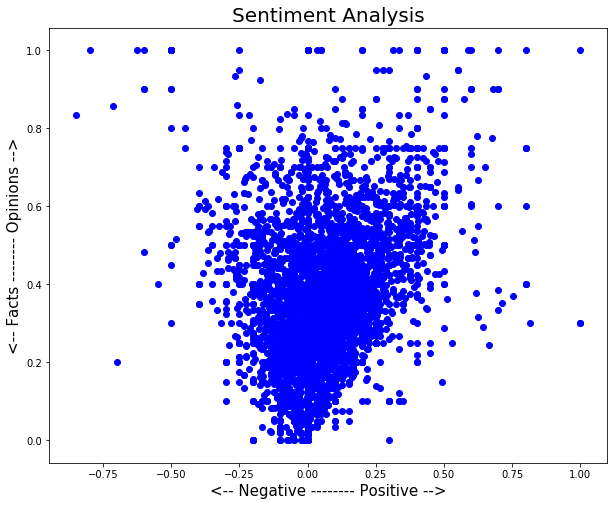

In [20]:
# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]
y = data_clean['subjectivity']
x = data_clean['polarity']
plt.scatter(x, y, color='blue')
   # plt.text(x+.001, y+.001, data['author'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)


plt.show()

Sentiment of any random news text

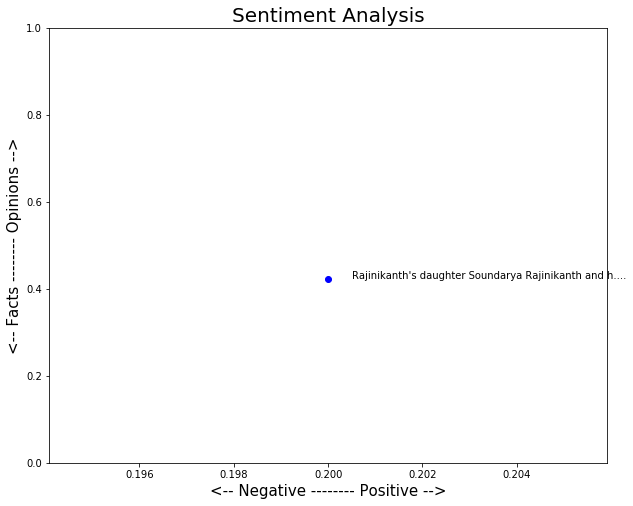

In [21]:
from random import randint
l=len(data_clean['text'])
v=randint(0,l)
val=data_clean.iloc[v,0]
val=val[:50]
val=val+"...."


# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]
y = data_clean.iloc[v,2]
x = data_clean.iloc[v,1]
plt.scatter(x, y, color='blue')
plt.text(x+.0005, y+.0005, val, fontsize=10)
#plt.xlim(-.01, .12) 
plt.ylim((0,1))  
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

#ax.bar(x, y);
#ax.set_xticks(x);
#ax.set_xticklabels(y);

plt.show()

Let's develop a list of the top words used across all one million news texts, giving us a glimpse into the core vocabulary of the source data.

In [22]:
data_clean=data_clean.reset_index()

In [23]:
#reindexing
df4 = data_clean['text']
df4.index = data_clean['headlines']
#df4.head()

## Latent Semantic Analysis

In [24]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2016', 'aap', 'air', 'april', 'army', 'arvind', 'assembly', 'australian', 'bihar', 'bjp', 'board', 'central', 'centre', 'ceo', 'china', 'chinese', 'commission', 'congress', 'corporation', 'december', 'delhi', 'deputy', 'didn', 'doesn', 'don', 'donald', 'force', 'friday', 'gandhi', 'general', 'gujarat', 'high', 'home', 'jammu', 'january', 'july', 'kapil', 'kapoor', 'kashmir', 'kejriwal', 'khan', 'kohli', 'kumar', 'maharashtra', 'march', 'minister', 'ministry', 'mla', 'monday', 'mp', 'mumbai', 'municipal', 'nadu', 'narendra', 'notably', 'pakistan', 'pakistani', 'pradesh', 'president', 'prime', 'priyanka', 'punjab', 'rahul', 'ram', 'rukh', 'sabha', 'salman', 'samajwadi', 'saturday', 'secretary', 'sena', 'shah', 'sharma', 'singh', 'south', 'sunday', 'supreme', 'tamil', 'test', 'thursday', 'tr

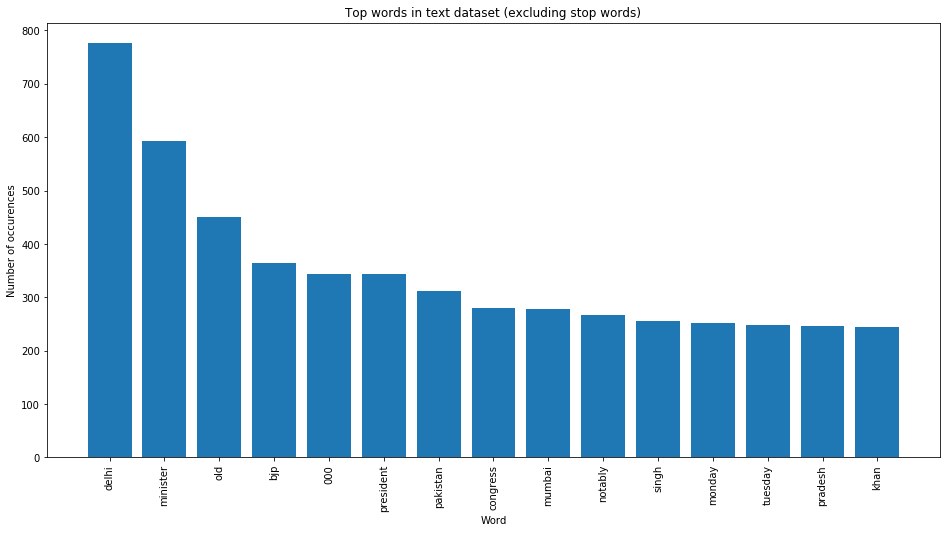

In [25]:
count_vectorizer = CountVectorizer(stop_words=stop_word)
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df4)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in text dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Next we generate a histogram of text word lengths, and use part-of-speech tagging to understand the types of words used across the corpus. This requires first converting all headline strings to TextBlobs and calling the pos_tags method on each, yielding a list of tagged words for each text.

In [26]:
tagged_headlines = [TextBlob(df4[i]).pos_tags for i in range(df4.shape[0])]

In [27]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per text: ', np.mean(word_counts))

Total number of words:  268680
Mean number of words per text:  59.52148870181657


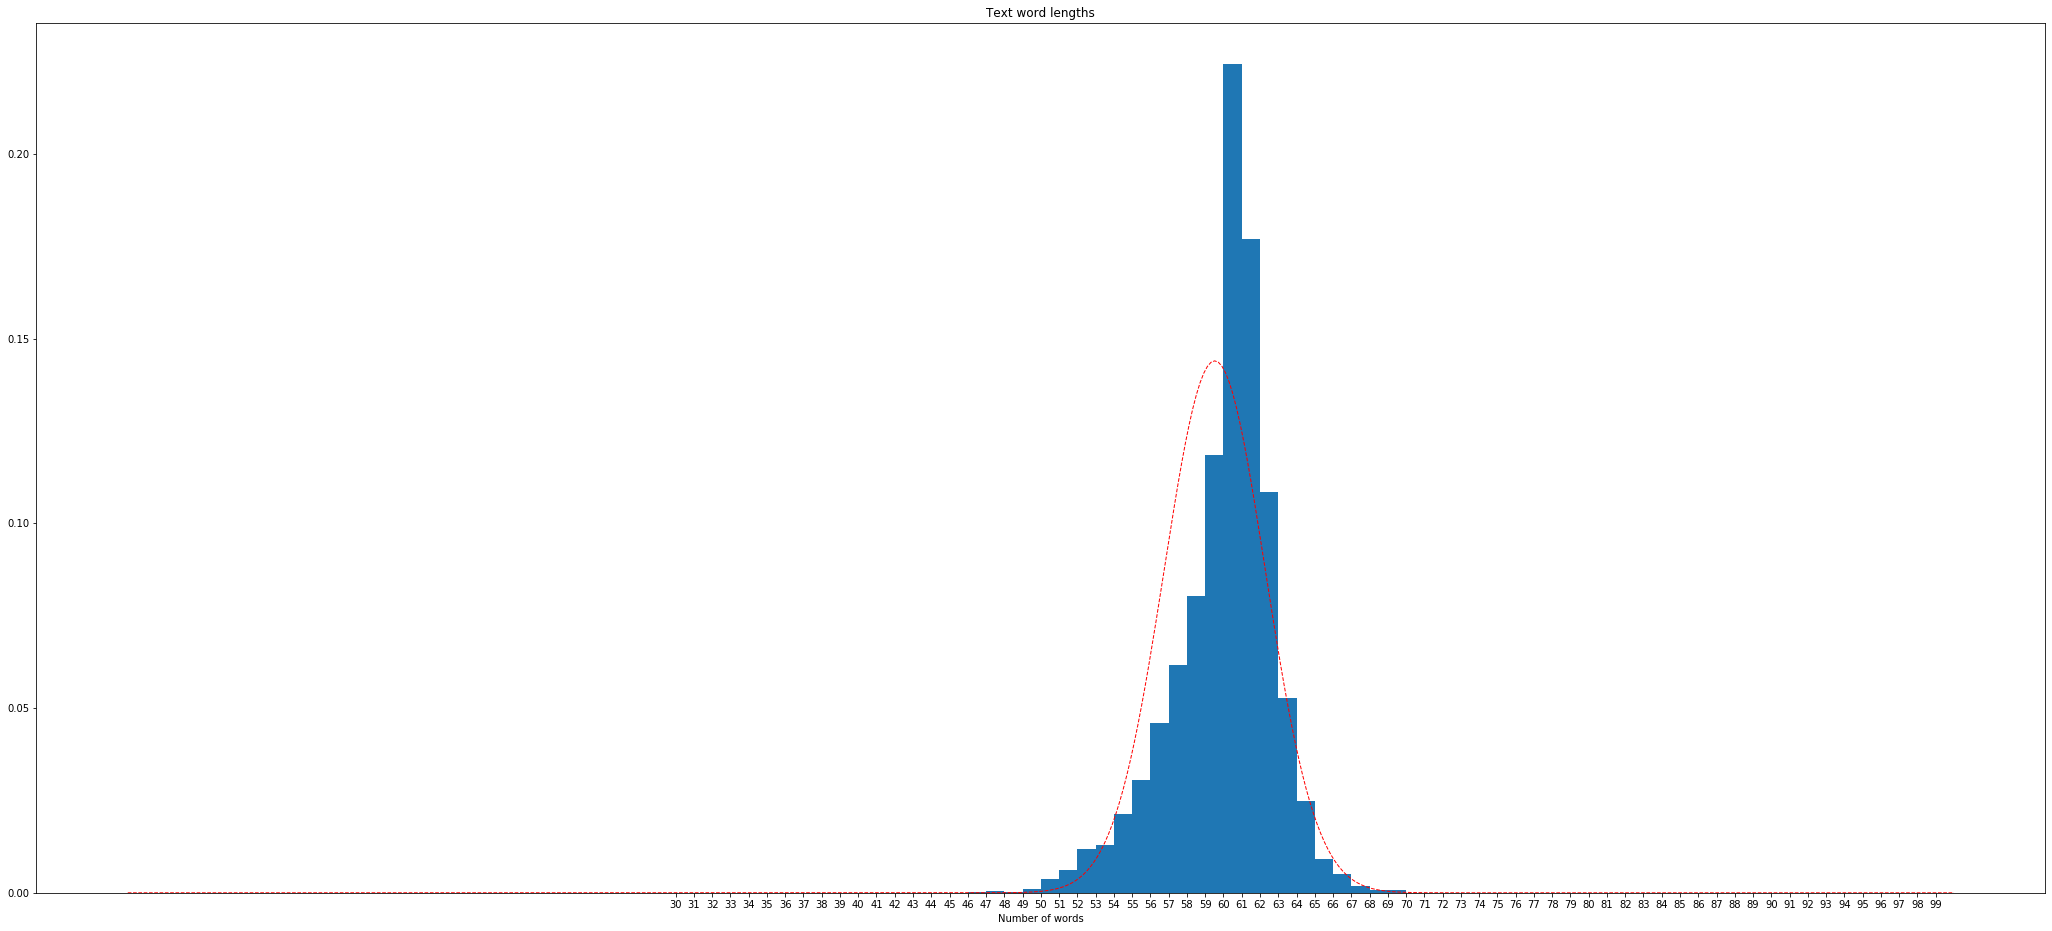

In [28]:
y = stats.norm.pdf(np.linspace(0,100,500), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(36,16))
ax.hist(word_counts, bins=range(1,100), density=True);
ax.plot(np.linspace(0,100,500), y, 'r--', linewidth=1);
ax.set_title('Text word lengths');
ax.set_xticks(range(30,100));
ax.set_xlabel('Number of words');
plt.show()

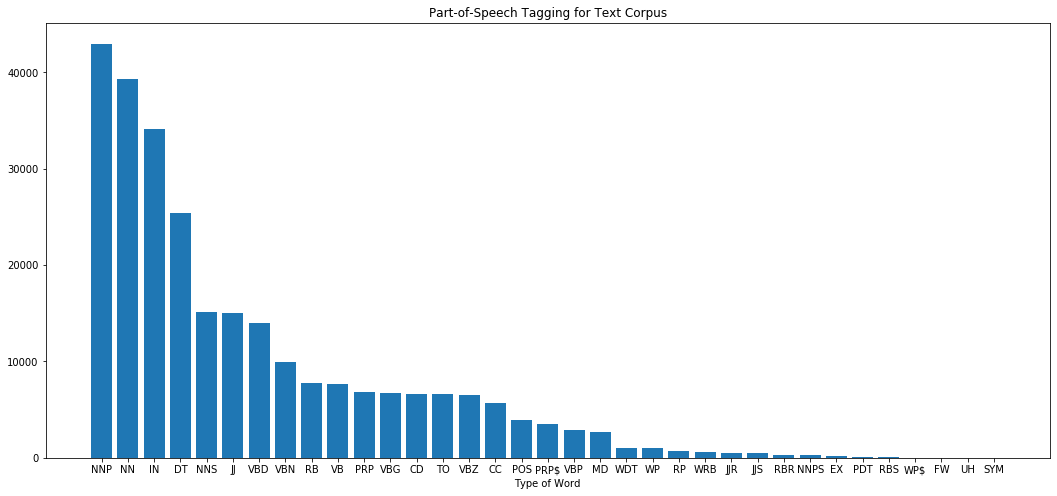

In [29]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Text Corpus');
ax.set_xlabel('Type of Word');

Using the CountVectorizer object from SKLearn, which yields an n×K document-term matrix where K  is the number of distinct words across the n  headlines in our sample


In [30]:
small_count_vectorizer = CountVectorizer(stop_words=stop_word, max_features=40000)
small_text_sample = df4.sample(n=4000, random_state=0).values

print('Text before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Text after vectorization: \n{}'.format(small_document_term_matrix[123]))

Text before vectorization: As many as 33 ministers and 359 MLAs in Uttar Pradesh have failed to declare their assets despite CM Yogi Adityanath's repeated directions, according to a government notification. As per rules, ministers and MLAs are mandated to declare their assets and liabilities within three months of assuming office or being elected as members of the state assembly.


C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2016', 'aap', 'air', 'april', 'army', 'arvind', 'assembly', 'australian', 'bihar', 'bjp', 'board', 'central', 'centre', 'ceo', 'china', 'chinese', 'commission', 'congress', 'corporation', 'december', 'delhi', 'deputy', 'didn', 'doesn', 'don', 'donald', 'force', 'friday', 'gandhi', 'general', 'gujarat', 'high', 'home', 'jammu', 'january', 'july', 'kapil', 'kapoor', 'kashmir', 'kejriwal', 'khan', 'kohli', 'kumar', 'maharashtra', 'march', 'minister', 'ministry', 'mla', 'monday', 'mp', 'mumbai', 'municipal', 'nadu', 'narendra', 'notably', 'pakistan', 'pakistani', 'pradesh', 'president', 'prime', 'priyanka', 'punjab', 'rahul', 'ram', 'rukh', 'sabha', 'salman', 'samajwadi', 'saturday', 'secretary', 'sena', 'shah', 'sharma', 'singh', 'south', 'sunday', 'supreme', 'tamil', 'test', 'thursday', 'tr

Text after vectorization: 
  (0, 12257)	1
  (0, 1637)	1
  (0, 16925)	1
  (0, 5516)	1
  (0, 10294)	2
  (0, 13834)	1
  (0, 4552)	2
  (0, 10389)	2
  (0, 364)	1
  (0, 383)	1
  (0, 1647)	2
  (0, 4784)	1
  (0, 17744)	1
  (0, 858)	1
  (0, 13392)	1
  (0, 4968)	1
  (0, 11062)	1
  (0, 9822)	1
  (0, 9352)	1
  (0, 1665)	1


In [31]:
n_topics = 10

Let's start by experimenting with LSA. This is effectively just a truncated singular value decomposition of a (very high-rank and sparse) document-term matrix, with only the   r= n_topics largest singular values preserved.

In [32]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

Taking the  argmax  of each headline in this topic matrix will give the predicted topics of each headline in the sample. We can then sort these into counts of each topic.

However, these topic categories are in and of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [33]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

However, these topic categories are in and of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [34]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [35]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [36]:
#get top n word from lsa model
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  delhi minister pradesh bjp monday tuesday old friday narendra wednesday
Topic 2:  delhi metro cisf gang selfie parking solar nikalo dilli capsules
Topic 3:  old mumbai pakistan china notably 2016 kashmir pakistani air army
Topic 4:  bjp congress president gandhi assembly pradesh elections rahul vice uttar
Topic 5:  pakistan kashmir pakistani minister army terrorism swaraj border china lahore
Topic 6:  khan salman shah rukh kapoor bollywood filmmaker aamir debut kapil
Topic 7:  president trump donald mukherjee russian visit kovind presidential pranab notably
Topic 8:  000 500 mumbai maharashtra jio firm centre 50 employees loan
Topic 9:  singh punjab sachin congress yadav amarinder kapil sushant cricketer minister
Topic 10:  test kohli virat australian australia tamil ganguly kumar coach england


Create a word cloud of topics

Topic 1: 


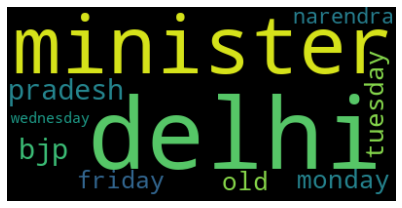

Topic 2: 


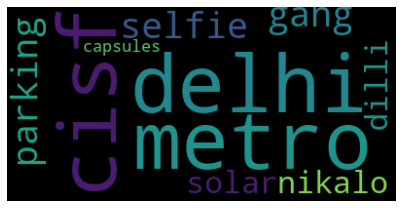

Topic 3: 


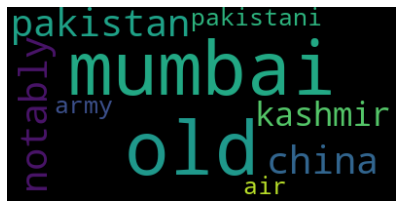

Topic 4: 


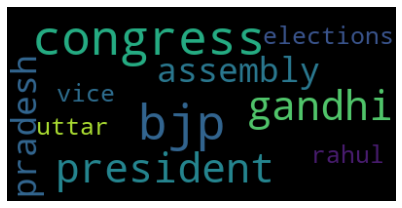

Topic 5: 


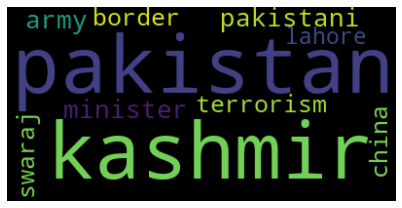

Topic 6: 


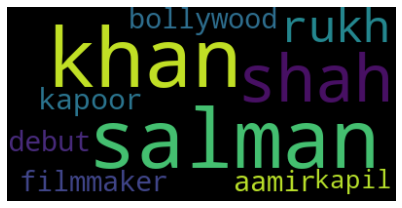

Topic 7: 


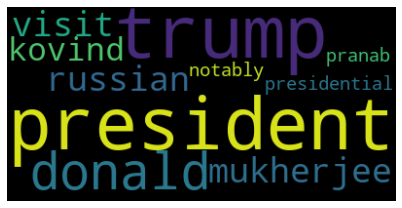

Topic 8: 


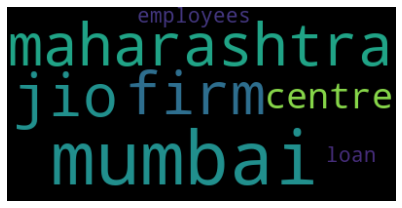

Topic 9: 


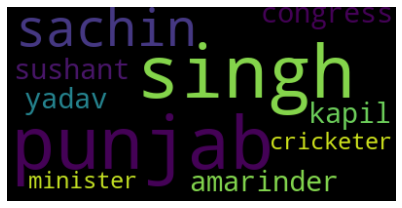

Topic 10: 


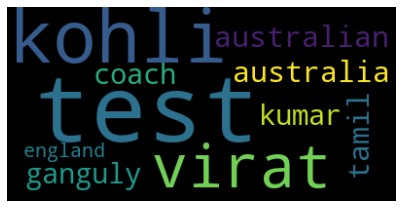

In [37]:
import matplotlib.pyplot as pPlot
from wordcloud import WordCloud, STOPWORDS
import numpy as npy
from PIL import Image

plt.rcParams['figure.figsize'] = [32, 24]

# Create and generate a word cloud image:
for i in range(len(top_n_words_lsa)):
    plt.subplot(3, 4, n_topics)
    print("Topic {}: ".format(i+1))
    wordcloud = WordCloud().generate(top_n_words_lsa[i])
    
# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

     

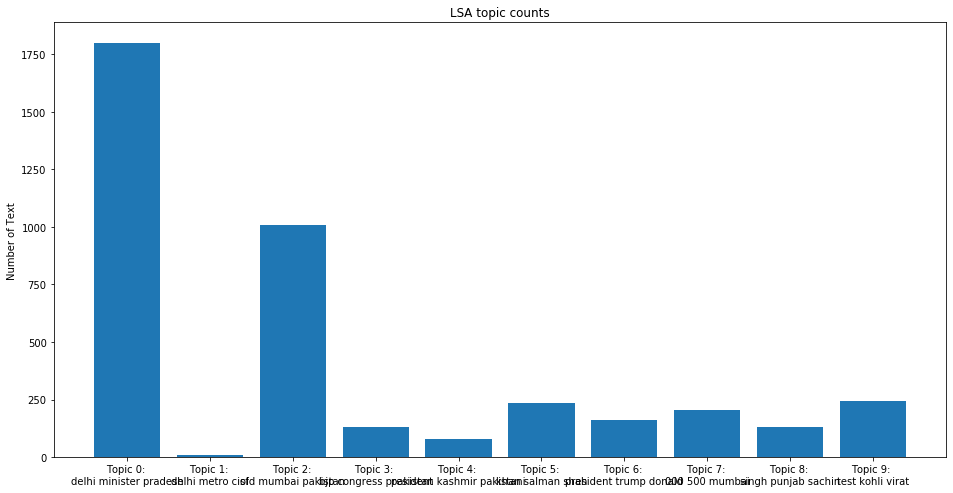

In [38]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of Text');
ax.set_title('LSA topic counts');
plt.show()

Use a dimensionality-reduction technique called t -SNE, which will also serve to better illuminate the success of the clustering process.

In [39]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.010s...
[t-SNE] Computed neighbors for 4000 samples in 0.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.083493
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.949348
[t-SNE] KL divergence after 2000 iterations: 0.789072


Now that we have reduced these n_topics-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [40]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [41]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [42]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

## LDA

##repeat this process using LDA instead of LSA. LDA is instead a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [43]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

Once again, we take the  argmax of each entry in the topic matrix to obtain the predicted topic category for each headline. These topic categories can then be characterised by their most frequent words.

In [44]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [45]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  khan salman kapil shah rukh sharma filmmaker bollywood army dutt
Topic 2:  delhi president china test 000 minister tuesday railway old friday
Topic 3:  minister bjp congress delhi singh kumar narendra yadav kejriwal prime
Topic 4:  goa air jallikattu assembly muslims minister rajinikanth mp bjp cow
Topic 5:  old delhi kapoor monday mumbai dead mother friday baby bus
Topic 6:  delhi air mumbai university 000 2016 old minister aircraft airport
Topic 7:  delhi 000 supreme high friday mumbai notably wednesday old monday
Topic 8:  pradesh bjp uttar minister yadav old sunday title adityanath saturday
Topic 9:  pakistan kohli trump president bcci test virat donald australia coach
Topic 10:  tamil delhi nadu minister sasikala aiadmk old jayalalithaa tuesday doctors


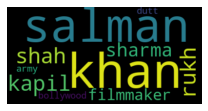

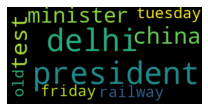

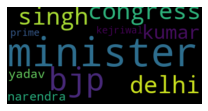

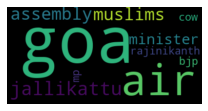

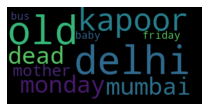

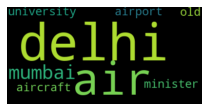

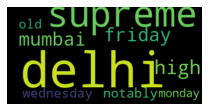

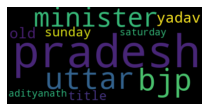

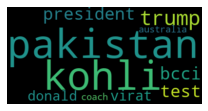

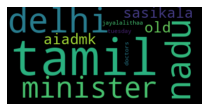

In [46]:
import matplotlib.pyplot as pPlot
from wordcloud import WordCloud, STOPWORDS
import numpy as npy
from PIL import Image
plt.rcParams['figure.figsize'] = [16, 12]
# Create and generate a word cloud image:

for i in range(len(top_n_words_lda)):
    plt.subplot(3, 4, n_topics)
    wordcloud = WordCloud().generate(top_n_words_lda[i])

# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

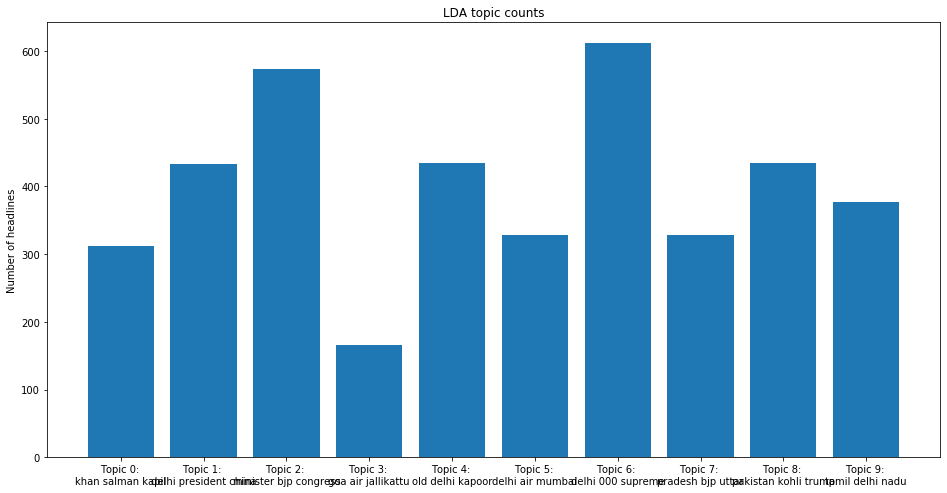

In [47]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [48]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.012s...
[t-SNE] Computed neighbors for 4000 samples in 0.556s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.122910
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.701797
[t-SNE] KL divergence after 2000 iterations: 1.233097


In [49]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

This is a much better result! Controlling for t -SNE, it would seem that LDA has had much more succcess than LSA in separating out the topic categories.

It is upto human intelligence to categorise topics


Topic 1:  khan salman kapil shah rukh sharma filmmaker bollywood army dutt

Category: entertainment

Topic 2:  delhi president china test minister tuesday railway old friday

Category: international, politics

Topic 3:  minister bjp congress delhi singh kumar narendra yadav kejriwal prime

Category: politics

Topic 4:  goa air jallikattu assembly muslims minister rajinikanth mp bjp cow

Category: politics

Topic 5:  old delhi kapoor monday mumbai dead mother friday baby bus

Category: domestic

Topic 6:  delhi air mumbai university  old minister aircraft airport

Category: domestic, airways

Topic 7:  delhi supreme high friday mumbai notably wednesday old monday

Category: law

Topic 8:  pradesh bjp uttar minister yadav old sunday title adityanath saturday

Category: politics

Topic 9:  pakistan kohli trump president bcci test virat donald australia coach

Category: sports,international

Topic 10: tamil delhi nadu minister sasikala aiadmk old jayalalithaa tuesday doctors

Category: politics